# Imputacion de Datos Faltantes para la Precipitacion del Meta mediante modelación XGBOOST

Este Jupyter Notebook se enfoca en el desarrolo metodologico del trabajo de grado de los estudiantes Ronaldo Hernandez Mejia y Hector Freddy Velasco, en el cual se enfoca en la imputaciopn de datos faltnates para la variable de precipitacion en el departamento del Meta, Colombia. Con una gran volumen de datos de la informacion diaria de la precipitacion desde 1980 hasta el 2016, seleccionando un total de 56 Estaciones meteorologias del IDEAM.

La región del Meta es muy importante en este país por la diversidad del clima y su efecto sobre la agricultura y otros sectores económicos. La variabilidad de las precipitaciones juega un papel importante en el análisis del clima y la toma de decisiones relacionadas con  la gestión del agua y el clima. 

El objetivo principal es desarrolar un modelo basado en el algotimo K-Nearest Neighbors(KNN) para imputar los datos faltantes de precipitacion, utilizando un conjunto de datos que contiene mas de 700.000 observaciones. 

Dada la gran cantidad de datos se ha implementado una version que utiliza los cores del procesador para ejecutar el modelo en paralelo optimizando asi el tiempo de ejecucion, mejorando la eficiencia computacional y acelerar el proceso, tambien por este motivo el desarrolo en python tiene tiempos de respuesta cortos en el manejo de datos.



### instalacion de librerias

In [2]:
import subprocess
import sys
import importlib

def install_and_import(package):
    try:
        importlib.import_module(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    finally:
        globals()[package] = importlib.import_module(package)


In [3]:
packages = ['pandas', 'IPython', 'pandasgui', 'numpy', 'matplotlib','joblib','sklearn','xgboost','xgbimputer']


for package in packages:
    install_and_import(package)


En caso de que no funcione instalacion manual:

In [3]:
import os
#observar donde estoy en ruta 
os.getcwd()

'f:\\TESIS\\Proyecto_mod_precipitacion\\Codigos de Python'

ruta ronaldo 

In [4]:
import os
current_path = os.getcwd()
print(f"Ruta actual del directorio de trabajo: {current_path}")
new_path = "F:\\TESIS\\Proyecto_mod_precipitacion"
os.chdir(new_path)
new_current_path = os.getcwd()
print(f"Nueva ruta del directorio de trabajo: {new_current_path}")

Ruta actual del directorio de trabajo: f:\TESIS\Proyecto_mod_precipitacion\Codigos de Python
Nueva ruta del directorio de trabajo: F:\TESIS\Proyecto_mod_precipitacion


ruta hector 


In [4]:
import os
current_path = os.getcwd()
print(f"Ruta actual del directorio de trabajo: {current_path}")
new_path = "c:\\Users\\vhect\\Documents\\semestre 10\\TESIS\\Proyecto_mod_precipitacion"
os.chdir(new_path)
new_current_path = os.getcwd()
print(f"Nueva ruta del directorio de trabajo: {new_current_path}")

Ruta actual del directorio de trabajo: c:\Users\vhect\Documents\semestre 9\trabajo de grado\proyecto_prec_vsdcode\Proyecto_mod_precipitacion\Codigos de Python
Nueva ruta del directorio de trabajo: c:\Users\vhect\Documents\semestre 10\TESIS\Proyecto_mod_precipitacion


### Lectura de datos

In [5]:
import pandas as pd
data = pd.read_csv("Datos/datos_seleccionados_para_modelo_coordenadas.txt",sep=";")
data.head()


,Date,prec,ID,LAT,LON
0,1983-06-09,6.8,32010010,2.562833,-74.103083
1,1983-06-10,17.8,32010010,2.562833,-74.103083
2,1983-06-11,0.0,32010010,2.562833,-74.103083
3,1983-06-12,0.5,32010010,2.562833,-74.103083
4,1983-06-13,6.9,32010010,2.562833,-74.103083


In [6]:
# Asegurarte de que 'Date' es una columna datetime
data['Date'] = pd.to_datetime(data['Date'])

# Crear nuevas columnas para el año, mes y día
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Crear un nuevo dataframe con las columnas deseadas
new_data = data[['ID', 'Year', 'Month', 'Day', 'prec', 'LAT', 'LON']].copy()

In [7]:
new_data = new_data.sort_values('ID')

In [8]:
new_data = new_data.rename(columns={
    'Year': 'Año',
    'Month': 'Mes',
    'Day': 'Día',
    'prec': 'prec',
    'LAT': 'LAT',
    'LON': 'LON'
})


new_data2 = new_data.rename(columns={
    'Year': 'Año',
    'Month': 'Mes',
    'Day': 'Día',
    'prec': 'prec',
    'LAT': 'LAT',
    'LON': 'LON',
    'ID': 'ID'
})

In [9]:
new_data = new_data[['Año', 'Mes', 'Día', 'prec', 'LAT', 'LON']]
new_data2 = new_data2[['Año', 'Mes', 'Día', 'prec', 'LAT', 'LON','ID']]

## Separacion de datos completos y faltantes

Surge de la necesidad de tener la data completa para tener el registro de los datos observados reales, los cuales son los que brindaran el soporte a las matricas estadisticas de desempeño como el RMSE,MAE,PRMSE

In [10]:
# Separar los datos completos de los datos con valores faltantes en 'Prec'
data_completa = new_data.dropna(subset=['prec'])
data_faltantes = new_data[new_data['prec'].isna()]

#Que incluya la variable ID

data_completa2 = new_data2.dropna(subset=['prec'])
data_faltantes2 = new_data2[new_data['prec'].isna()]

Ahora para simular los datos faltantes reales del 8.27%, se imputaran el 10% de datos faltantes por medio de una funcion aletoria para un total de 59.212 datos faltantes, la funcion toma aletoriamente las posiciones de la variable seleccionada y realizara un extraccion de la informacion, dejando asi un registro faltante como resultado.

Esto con el objetivo de simular la situacion del modelo en una naturaleza de los datos completamente al azar,En el proceso de análisis de datos, especialmente en contextos donde la imputación de datos faltantes es crucial, es importante simular condiciones realistas para evaluar la robustez y eficacia de los métodos de imputación. Esto se logra a través de la inserción controlada de datos faltantes en el conjunto de datos original. La introducción de un porcentaje específico de datos faltantes, en este caso, un 10%, se basa en la necesidad de replicar escenarios comunes en la recopilación de datos donde la ausencia de información puede deberse a errores de medición, fallas de los sensores, o problemas en la transmisión de datos (Rubin, 1976; Little & Rubin, 1987)\cite{rubin1976, little1987}.

In [11]:
import numpy as np
import pandas as pd

def insertar_nan_aleatoriamente(df, nombre_columna, fraccion, semilla=42):
    np.random.seed(semilla)  # Establecer la semilla
    df = df.copy()
    df['Original'] = df[nombre_columna]
    indices_a_modificar = df[nombre_columna].dropna().sample(frac=fraccion).index
    df.loc[indices_a_modificar, nombre_columna] = np.nan
    return df

#Esta función con la misma semilla
data_completa_mod = insertar_nan_aleatoriamente(data_completa, 'prec', 0.1)
data_completa_mod2 = insertar_nan_aleatoriamente(data_completa2, 'prec', 0.1)


para el 15%

In [10]:
import numpy as np
import pandas as pd

def insertar_nan_aleatoriamente(df, nombre_columna, fraccion, semilla=42):
    np.random.seed(semilla)  # Establecer la semilla
    df = df.copy()
    df['Original'] = df[nombre_columna]
    indices_a_modificar = df[nombre_columna].dropna().sample(frac=fraccion).index
    df.loc[indices_a_modificar, nombre_columna] = np.nan
    return df

#Esta función con la misma semilla
data_completa_mod15p = insertar_nan_aleatoriamente(data_completa, 'prec', 0.15)
data_completa_mod215p = insertar_nan_aleatoriamente(data_completa2, 'prec', 0.15)


para el 20%

In [11]:
import numpy as np
import pandas as pd

def insertar_nan_aleatoriamente(df, nombre_columna, fraccion, semilla=42):
    np.random.seed(semilla)  # Establecer la semilla
    df = df.copy()
    df['Original'] = df[nombre_columna]
    indices_a_modificar = df[nombre_columna].dropna().sample(frac=fraccion).index
    df.loc[indices_a_modificar, nombre_columna] = np.nan
    return df

#Esta función con la misma semilla
data_completa_mod20p = insertar_nan_aleatoriamente(data_completa, 'prec', 0.20)
data_completa_mod220p = insertar_nan_aleatoriamente(data_completa2, 'prec', 0.20)

In [12]:
data_completa_mod2.info()
data_completa_mod2.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592124 entries, 0 to 656435
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Año       592124 non-null  int64  
 1   Mes       592124 non-null  int64  
 2   Día       592124 non-null  int64  
 3   prec      532912 non-null  float64
 4   LAT       592124 non-null  float64
 5   LON       592124 non-null  float64
 6   ID        592124 non-null  int64  
 7   Original  592124 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 56.8 MB


,Año,Mes,Día,prec,LAT,LON,ID,Original
0,1983,6,9,6.8,2.562833,-74.103083,32010010,6.8
8045,2005,6,18,8.0,2.562833,-74.103083,32010010,8.0
8046,2005,6,19,NaN,2.562833,-74.103083,32010010,12.0
8047,2005,6,20,0.0,2.562833,-74.103083,32010010,0.0
8048,2005,6,21,4.0,2.562833,-74.103083,32010010,4.0
8049,2005,6,22,0.0,2.562833,-74.103083,32010010,0.0
8050,2005,6,23,NaN,2.562833,-74.103083,32010010,3.0
8051,2005,6,24,NaN,2.562833,-74.103083,32010010,41.0
8052,2005,6,25,8.0,2.562833,-74.103083,32010010,8.0
8053,2005,6,26,3.0,2.562833,-74.103083,32010010,3.0


## Visualización datos faltantes para la data completa modificada

<Figure size 720x432 with 0 Axes>

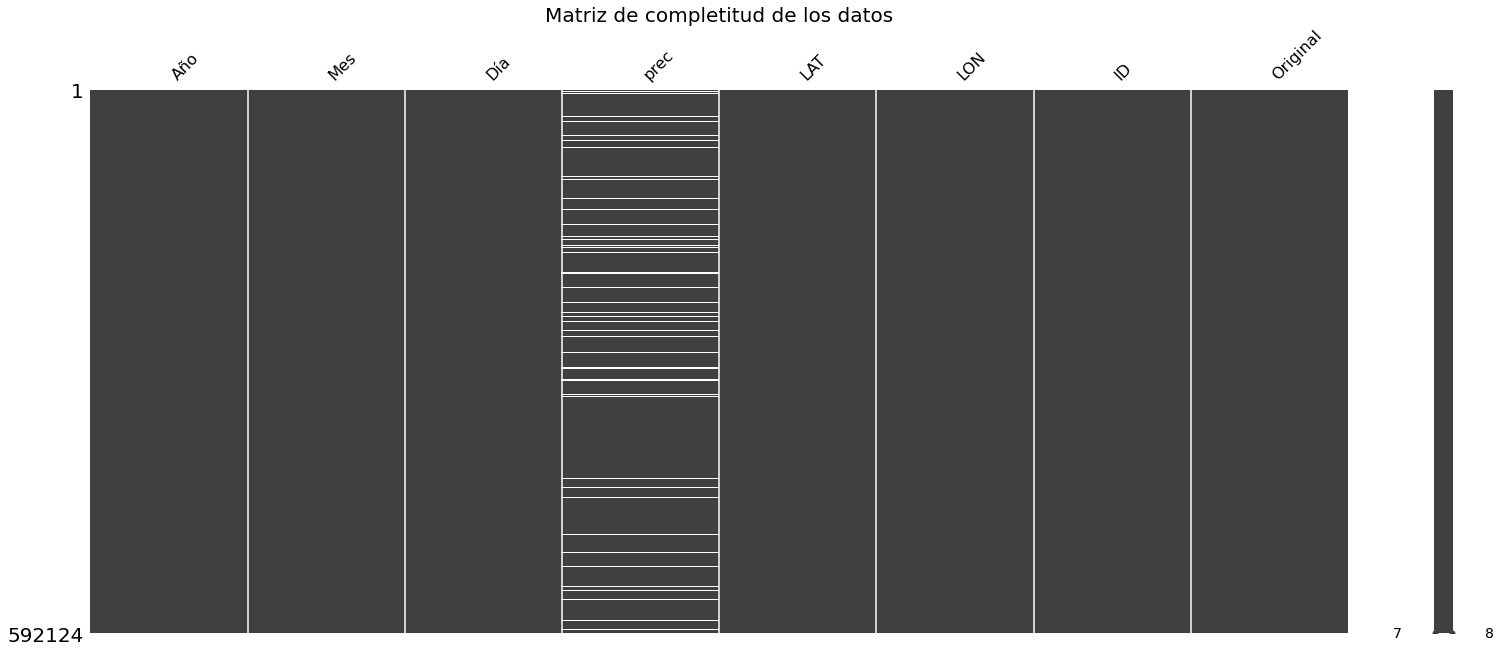

In [13]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

# Suponemos que 'data' es tu DataFrame

# Visualizar la completitud de los datos con matriz
plt.figure(figsize=(10,6))
msno.matrix(data_completa_mod2)
plt.title('Matriz de completitud de los datos', fontsize=20)
plt.show()

In [32]:
soloNAn=na_rows = data_completa_mod2[data_completa_mod2['prec'].isna()]
soloNAn

,Año,Mes,Día,prec,LAT,LON,ID,Original
8046,2005,6,19,NaN,2.562833,-74.103083,32010010,12.0
8050,2005,6,23,NaN,2.562833,-74.103083,32010010,3.0
8051,2005,6,24,NaN,2.562833,-74.103083,32010010,41.0
8021,2005,5,25,NaN,2.562833,-74.103083,32010010,0.0
8028,2005,6,1,NaN,2.562833,-74.103083,32010010,8.0
...,...,...,...,...,...,...,...,...
654363,2008,11,14,NaN,4.260361,-72.564472,35185010,0.0
654368,2008,11,19,NaN,4.260361,-72.564472,35185010,1.2
654246,2008,7,20,NaN,4.260361,-72.564472,35185010,0.1
654280,2008,8,23,NaN,4.260361,-72.564472,35185010,0.6


## Analisis exploratorio

count    592124.000000
mean          8.915141
std          17.865258
min           0.000000
25%           0.000000
50%           0.000000
75%          10.000000
max         438.800000
Name: prec, dtype: float64


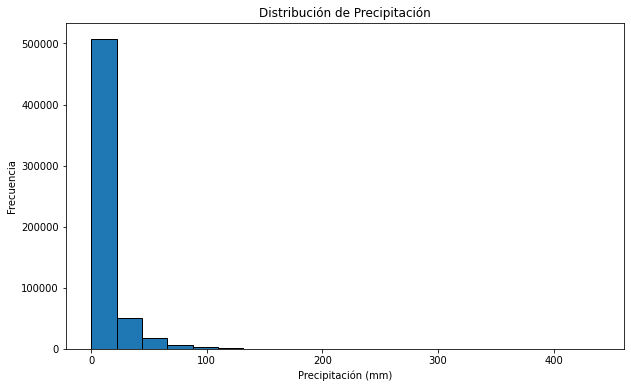

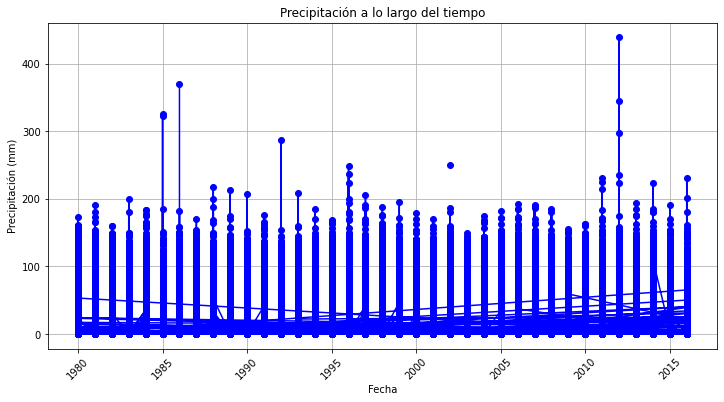

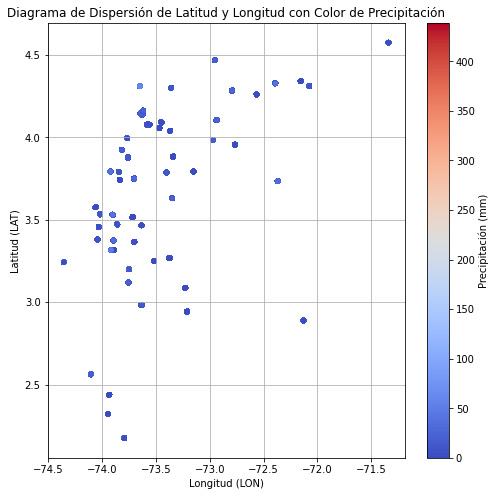

In [33]:
import pandas as pd
import matplotlib.pyplot as plt


# Resumen estadístico de la columna de precipitación
print(data['prec'].describe())

# Histograma de la precipitación
plt.figure(figsize=(10, 6))
plt.hist(data['prec'], bins=20, edgecolor='k')
plt.title('Distribución de Precipitación')
plt.xlabel('Precipitación (mm)')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de línea de la precipitación a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(data['Year'], data['prec'], marker='o', linestyle='-', color='b')
plt.title('Precipitación a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precipitación (mm)')
plt.xticks(rotation=45)  # Para mostrar las fechas de manera legible
plt.grid()
plt.show()

# Diagrama de dispersión de latitud y longitud
plt.figure(figsize=(8, 8))
plt.scatter(data['LON'], data['LAT'], c=data['prec'], cmap='coolwarm', s=20)
plt.title('Diagrama de Dispersión de Latitud y Longitud con Color de Precipitación')
plt.xlabel('Longitud (LON)')
plt.ylabel('Latitud (LAT)')
plt.colorbar(label='Precipitación (mm)')
plt.grid()
plt.show()


## Correlación entre variables

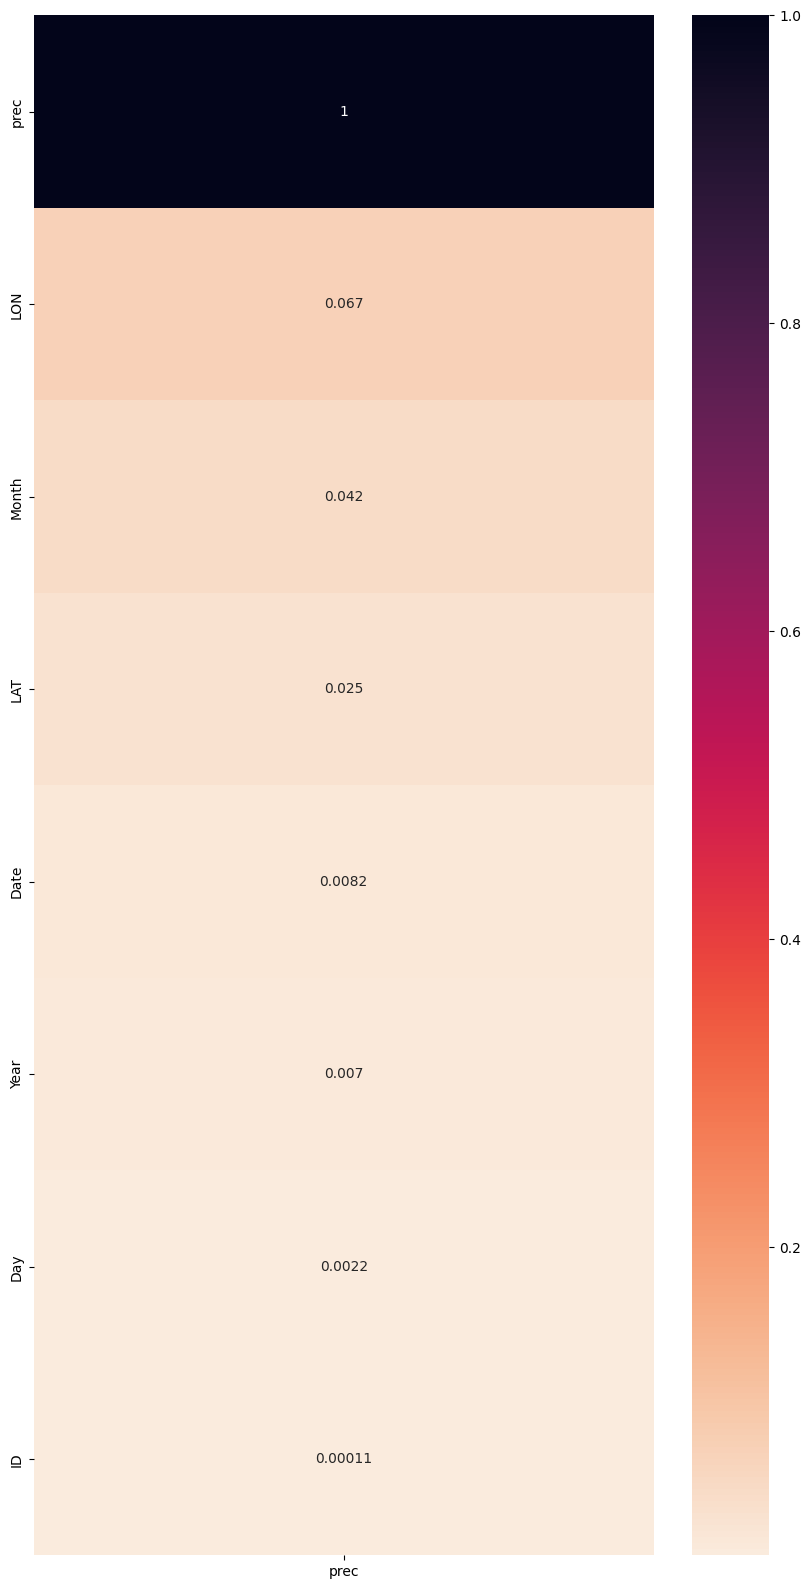

In [16]:
import seaborn as sns
plt.figure(figsize=(10,20))
sns.heatmap(abs(data.corr()[['prec']]).sort_values(by='prec',ascending=False), annot=True, cmap=sns.cm.rocket_r)
plt.show()

Estructura de los datos

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656436 entries, 0 to 656435
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    656436 non-null  datetime64[ns]
 1   prec    592124 non-null  float64       
 2   ID      656436 non-null  int64         
 3   LAT     656436 non-null  float64       
 4   LON     656436 non-null  float64       
 5   Year    656436 non-null  int64         
 6   Month   656436 non-null  int64         
 7   Day     656436 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4)
memory usage: 40.1 MB


Visualizacion de los datos faltantes 

## Porcentaje de missing values para la precipitación

In [17]:
import pandas as pd

# Agrupar por la columna 'ID' (identificación de la estación)
grouped_data = data.groupby('ID')

# Calcular el porcentaje de valores faltantes en precipitación por estación
missing_precipitation_percentage = grouped_data['prec'].apply(lambda x: (x.isna().sum() / len(x)) * 100)

# Crear un nuevo DataFrame con ID, LAT, LON y el porcentaje de valores faltantes en precipitación
result_df = data.groupby('ID').agg({'LAT': 'first', 'LON': 'first'})
result_df['Missing_Precipitation_Percentage'] = missing_precipitation_percentage

# Ordenar la tabla por el porcentaje de valores faltantes en precipitación de mayor a menor
result_df = result_df.sort_values(by='Missing_Precipitation_Percentage', ascending=False)

# Mostrar el nuevo DataFrame
result_df


,LAT,LON,Missing_Precipitation_Percentage
ID,,,
35035010,4.077111,-73.559917,46.517451
35010230,3.984639,-72.971222,44.462837
35185010,4.260361,-72.564472,36.246154
32120010,3.734083,-72.369778,34.925172
32060090,3.576222,-74.059639,31.858780
35030370,4.137389,-73.625000,28.718226
35010150,3.883333,-73.340000,28.170546
35035070,4.076722,-73.582000,23.521008
32075030,3.120389,-73.754028,20.390098


In [18]:
# Contar el número de estaciones únicas basadas en la columna 'ID'
num_unique_stations = data['ID'].nunique()

# Mostrar el número de estaciones únicas
print("Número de estaciones únicas:", num_unique_stations)


Número de estaciones únicas: 57


## Estaciones con porcentaje de missing values mayor o igual 10%

In [19]:
# Filtrar las estaciones con un porcentaje de valores faltantes en precipitación mayor o igual al 10%
filtered_stations = result_df[result_df['Missing_Precipitation_Percentage'] >= 10]

# Mostrar las estaciones filtradas
filtered_stations


,LAT,LON,Missing_Precipitation_Percentage
ID,,,
35035010,4.077111,-73.559917,46.517451
35010230,3.984639,-72.971222,44.462837
35185010,4.260361,-72.564472,36.246154
32120010,3.734083,-72.369778,34.925172
32060090,3.576222,-74.059639,31.858780
35030370,4.137389,-73.625000,28.718226
35010150,3.883333,-73.340000,28.170546
35035070,4.076722,-73.582000,23.521008
32075030,3.120389,-73.754028,20.390098


In [20]:
# Contar el número de estaciones únicas basadas en la columna 'ID'
num_unique_stations = filtered_stations['Missing_Precipitation_Percentage'].nunique()

# Mostrar el número de estaciones únicas
print("Número de estaciones únicas:", num_unique_stations)


Número de estaciones únicas: 18


Se realiza un filtro de las estaciones de monitoreo con un porcentaje de datos faltantes para la precipitación mayor o igual al 10%, ya que esto es un porcentaje significativo de datos faltantes, reduciendo el numero de estaciones a 18, y así enfocarnos en la muestra de resultados a estas estaciones, considerando que es más probable que se requieran acciones correctivas o una mayor atención.

In [36]:
data_completa_mod

,Año,Mes,Día,prec,LAT,LON,Original
0,1983,6,9,6.8,2.562833,-74.103083,6.8
8045,2005,6,18,8.0,2.562833,-74.103083,8.0
8046,2005,6,19,NaN,2.562833,-74.103083,12.0
8047,2005,6,20,0.0,2.562833,-74.103083,0.0
8048,2005,6,21,4.0,2.562833,-74.103083,4.0
...,...,...,...,...,...,...,...
654265,2008,8,8,0.0,4.260361,-72.564472,0.0
654268,2008,8,11,3.7,4.260361,-72.564472,3.7
654269,2008,8,12,0.1,4.260361,-72.564472,0.1
654264,2008,8,7,0.1,4.260361,-72.564472,0.1


In [35]:
data_completa_mod2

,Año,Mes,Día,prec,LAT,LON,ID,Original
0,1983,6,9,6.8,2.562833,-74.103083,32010010,6.8
8045,2005,6,18,8.0,2.562833,-74.103083,32010010,8.0
8046,2005,6,19,NaN,2.562833,-74.103083,32010010,12.0
8047,2005,6,20,0.0,2.562833,-74.103083,32010010,0.0
8048,2005,6,21,4.0,2.562833,-74.103083,32010010,4.0
...,...,...,...,...,...,...,...,...
654265,2008,8,8,0.0,4.260361,-72.564472,35185010,0.0
654268,2008,8,11,3.7,4.260361,-72.564472,35185010,3.7
654269,2008,8,12,0.1,4.260361,-72.564472,35185010,0.1
654264,2008,8,7,0.1,4.260361,-72.564472,35185010,0.1


In [14]:
data_completa_modelo = pd.DataFrame(data_completa_mod)

# Separando la columna 'Original'
original = data_completa_modelo.pop("Original")

# Mostrando el DataFrame modificado y la columna 'Original' separada
data_completa_modelo, original

(         Año  Mes  Día  prec       LAT        LON
 0       1983    6    9   6.8  2.562833 -74.103083
 8045    2005    6   18   8.0  2.562833 -74.103083
 8046    2005    6   19   NaN  2.562833 -74.103083
 8047    2005    6   20   0.0  2.562833 -74.103083
 8048    2005    6   21   4.0  2.562833 -74.103083
 ...      ...  ...  ...   ...       ...        ...
 654265  2008    8    8   0.0  4.260361 -72.564472
 654268  2008    8   11   3.7  4.260361 -72.564472
 654269  2008    8   12   0.1  4.260361 -72.564472
 654264  2008    8    7   0.1  4.260361 -72.564472
 656435  2014    7   18   NaN  4.260361 -72.564472
 
 [592124 rows x 6 columns],
 0          6.8
 8045       8.0
 8046      12.0
 8047       0.0
 8048       4.0
           ... 
 654265     0.0
 654268     3.7
 654269     0.1
 654264     0.1
 656435     0.0
 Name: Original, Length: 592124, dtype: float64)

para el 15%

In [12]:
data_completa_modelo15p = pd.DataFrame(data_completa_mod15p)

# Separando la columna 'Original'
original15p = data_completa_modelo15p.pop("Original")


para el 20%

In [13]:
data_completa_modelo20p = pd.DataFrame(data_completa_mod20p)

# Separando la columna 'Original'
original20p = data_completa_modelo20p.pop("Original")

## Utilizando el Repo de XGBOOST imputer

In [51]:
data_completa_modelo.columns

Index(['Año', 'Mes', 'Día', 'prec', 'LAT', 'LON'], dtype='object')

In [61]:
data_completa_modelo

,Año,Mes,Día,prec,LAT,LON
0,1983,6,9,6.8,2.562833,-74.103083
8045,2005,6,18,8.0,2.562833,-74.103083
8046,2005,6,19,NaN,2.562833,-74.103083
8047,2005,6,20,0.0,2.562833,-74.103083
8048,2005,6,21,4.0,2.562833,-74.103083
...,...,...,...,...,...,...
654265,2008,8,8,0.0,4.260361,-72.564472
654268,2008,8,11,3.7,4.260361,-72.564472
654269,2008,8,12,0.1,4.260361,-72.564472
654264,2008,8,7,0.1,4.260361,-72.564472


In [19]:
import pandas as pd
import numpy as np
from xgbimputer import XGBImputer



In [70]:
data_completa_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592124 entries, 0 to 656435
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Año     592124 non-null  int64  
 1   Mes     592124 non-null  int64  
 2   Día     592124 non-null  int64  
 3   prec    532912 non-null  float64
 4   LAT     592124 non-null  float64
 5   LON     592124 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 47.7 MB


In [15]:
df=data_completa_modelo
df=pd.DataFrame(df)


para el 15%

In [15]:
df15p=data_completa_modelo15p
df15=pd.DataFrame(df15p)

para el 20%

In [16]:
df20p=data_completa_modelo20p
df20p=pd.DataFrame(df20p)

In [126]:
imputer2 = XGBImputer(categorical_features_index=[0,1,2], replace_categorical_values_back=True,n_jobs=-1)# establecer variables int64 que es entero y boolean data_completa_modelo
X334 = imputer2.fit_transform(df)

c:\Users\ronal\AppData\Local\Programs\Python\Python310\lib\site-packages\xgbimputer\xgbimputer.py:147: RuntimeWarning: invalid value encountered in scalar divide
  gamma_inferred_categorical_features_new = np.sum(Ximp[:,self.inferred_categorical_features_index] != Ximp_old[:,self.inferred_categorical_features_index])/self.inferred_categorical_features_index.size


XGBImputer - Epoch: 1 | Categorical gamma: inf/nan | Numerical gamma: inf/0.0087637099


c:\Users\ronal\AppData\Local\Programs\Python\Python310\lib\site-packages\xgbimputer\xgbimputer.py:147: RuntimeWarning: invalid value encountered in scalar divide
  gamma_inferred_categorical_features_new = np.sum(Ximp[:,self.inferred_categorical_features_index] != Ximp_old[:,self.inferred_categorical_features_index])/self.inferred_categorical_features_index.size


XGBImputer - Epoch: 2 | Categorical gamma: nan/nan | Numerical gamma: 0.0087637099/0.


c:\Users\ronal\AppData\Local\Programs\Python\Python310\lib\site-packages\xgbimputer\xgbimputer.py:147: RuntimeWarning: invalid value encountered in scalar divide
  gamma_inferred_categorical_features_new = np.sum(Ximp[:,self.inferred_categorical_features_index] != Ximp_old[:,self.inferred_categorical_features_index])/self.inferred_categorical_features_index.size


XGBImputer - Epoch: 3 | Categorical gamma: nan/nan | Numerical gamma: 0./0.


In [92]:
imputer = XGBImputer(categorical_features_index=[0,1,2], replace_categorical_values_back=True,n_jobs=-1)# establecer variables int64 que es entero y boolean data_completa_modelo
X = imputer.fit_transform(df)

c:\Users\ronal\AppData\Local\Programs\Python\Python310\lib\site-packages\xgbimputer\xgbimputer.py:147: RuntimeWarning: invalid value encountered in scalar divide
  gamma_inferred_categorical_features_new = np.sum(Ximp[:,self.inferred_categorical_features_index] != Ximp_old[:,self.inferred_categorical_features_index])/self.inferred_categorical_features_index.size


XGBImputer - Epoch: 1 | Categorical gamma: inf/nan | Numerical gamma: inf/0.0087637099


c:\Users\ronal\AppData\Local\Programs\Python\Python310\lib\site-packages\xgbimputer\xgbimputer.py:147: RuntimeWarning: invalid value encountered in scalar divide
  gamma_inferred_categorical_features_new = np.sum(Ximp[:,self.inferred_categorical_features_index] != Ximp_old[:,self.inferred_categorical_features_index])/self.inferred_categorical_features_index.size


XGBImputer - Epoch: 2 | Categorical gamma: nan/nan | Numerical gamma: 0.0087637099/0.


c:\Users\ronal\AppData\Local\Programs\Python\Python310\lib\site-packages\xgbimputer\xgbimputer.py:147: RuntimeWarning: invalid value encountered in scalar divide
  gamma_inferred_categorical_features_new = np.sum(Ximp[:,self.inferred_categorical_features_index] != Ximp_old[:,self.inferred_categorical_features_index])/self.inferred_categorical_features_index.size


XGBImputer - Epoch: 3 | Categorical gamma: nan/nan | Numerical gamma: 0./0.


In [93]:
type(X)

numpy.ndarray

In [94]:
numpy.ndarray

numpy.ndarray

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592124 entries, 0 to 656435
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Año     592124 non-null  int64  
 1   Mes     592124 non-null  int64  
 2   Día     592124 non-null  int64  
 3   prec    532912 non-null  float64
 4   LAT     592124 non-null  float64
 5   LON     592124 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 47.7 MB


In [95]:
pd.DataFrame(X).head(15)

,0,1,2,3,4,5
0,1983.0,6.0,9.0,6.8,2.562833,-74.103083
1,2005.0,6.0,18.0,8.0,2.562833,-74.103083
2,2005.0,6.0,19.0,13.232292,2.562833,-74.103083
3,2005.0,6.0,20.0,0.0,2.562833,-74.103083
4,2005.0,6.0,21.0,4.0,2.562833,-74.103083
5,2005.0,6.0,22.0,0.0,2.562833,-74.103083
6,2005.0,6.0,23.0,10.464192,2.562833,-74.103083
7,2005.0,6.0,24.0,11.294936,2.562833,-74.103083
8,2005.0,6.0,25.0,8.0,2.562833,-74.103083
9,2005.0,6.0,26.0,3.0,2.562833,-74.103083


In [20]:
imputer2 = XGBImputer(categorical_features_index=[0,1,2], replace_categorical_values_back=False)
X2 = imputer2.fit_transform(df)

c:\Users\ronal\AppData\Local\Programs\Python\Python310\lib\site-packages\xgbimputer\xgbimputer.py:147: RuntimeWarning: invalid value encountered in scalar divide
  gamma_inferred_categorical_features_new = np.sum(Ximp[:,self.inferred_categorical_features_index] != Ximp_old[:,self.inferred_categorical_features_index])/self.inferred_categorical_features_index.size


XGBImputer - Epoch: 1 | Categorical gamma: inf/nan | Numerical gamma: inf/0.0087637099


c:\Users\ronal\AppData\Local\Programs\Python\Python310\lib\site-packages\xgbimputer\xgbimputer.py:147: RuntimeWarning: invalid value encountered in scalar divide
  gamma_inferred_categorical_features_new = np.sum(Ximp[:,self.inferred_categorical_features_index] != Ximp_old[:,self.inferred_categorical_features_index])/self.inferred_categorical_features_index.size


XGBImputer - Epoch: 2 | Categorical gamma: nan/nan | Numerical gamma: 0.0087637099/0.
XGBImputer - Epoch: 3 | Categorical gamma: nan/nan | Numerical gamma: 0./0.


c:\Users\ronal\AppData\Local\Programs\Python\Python310\lib\site-packages\xgbimputer\xgbimputer.py:147: RuntimeWarning: invalid value encountered in scalar divide
  gamma_inferred_categorical_features_new = np.sum(Ximp[:,self.inferred_categorical_features_index] != Ximp_old[:,self.inferred_categorical_features_index])/self.inferred_categorical_features_index.size


para el 15%

In [17]:
imputer215p = XGBImputer(categorical_features_index=[0,1,2], replace_categorical_values_back=False)
X215p = imputer215p.fit_transform(df15p)

c:\Users\ronal\AppData\Local\Programs\Python\Python310\lib\site-packages\xgbimputer\xgbimputer.py:147: RuntimeWarning: invalid value encountered in scalar divide
  gamma_inferred_categorical_features_new = np.sum(Ximp[:,self.inferred_categorical_features_index] != Ximp_old[:,self.inferred_categorical_features_index])/self.inferred_categorical_features_index.size


XGBImputer - Epoch: 1 | Categorical gamma: inf/nan | Numerical gamma: inf/0.0137753424


c:\Users\ronal\AppData\Local\Programs\Python\Python310\lib\site-packages\xgbimputer\xgbimputer.py:147: RuntimeWarning: invalid value encountered in scalar divide
  gamma_inferred_categorical_features_new = np.sum(Ximp[:,self.inferred_categorical_features_index] != Ximp_old[:,self.inferred_categorical_features_index])/self.inferred_categorical_features_index.size


XGBImputer - Epoch: 2 | Categorical gamma: nan/nan | Numerical gamma: 0.0137753424/0.
XGBImputer - Epoch: 3 | Categorical gamma: nan/nan | Numerical gamma: 0./0.


c:\Users\ronal\AppData\Local\Programs\Python\Python310\lib\site-packages\xgbimputer\xgbimputer.py:147: RuntimeWarning: invalid value encountered in scalar divide
  gamma_inferred_categorical_features_new = np.sum(Ximp[:,self.inferred_categorical_features_index] != Ximp_old[:,self.inferred_categorical_features_index])/self.inferred_categorical_features_index.size


para el 20%

In [18]:
imputer220p = XGBImputer(categorical_features_index=[0,1,2], replace_categorical_values_back=False)
X220p = imputer215p.fit_transform(df20p)

c:\Users\ronal\AppData\Local\Programs\Python\Python310\lib\site-packages\xgbimputer\xgbimputer.py:147: RuntimeWarning: invalid value encountered in scalar divide
  gamma_inferred_categorical_features_new = np.sum(Ximp[:,self.inferred_categorical_features_index] != Ximp_old[:,self.inferred_categorical_features_index])/self.inferred_categorical_features_index.size


XGBImputer - Epoch: 1 | Categorical gamma: inf/nan | Numerical gamma: inf/0.0190212852


c:\Users\ronal\AppData\Local\Programs\Python\Python310\lib\site-packages\xgbimputer\xgbimputer.py:147: RuntimeWarning: invalid value encountered in scalar divide
  gamma_inferred_categorical_features_new = np.sum(Ximp[:,self.inferred_categorical_features_index] != Ximp_old[:,self.inferred_categorical_features_index])/self.inferred_categorical_features_index.size


XGBImputer - Epoch: 2 | Categorical gamma: nan/nan | Numerical gamma: 0.0190212852/0.
XGBImputer - Epoch: 3 | Categorical gamma: nan/nan | Numerical gamma: 0./0.


c:\Users\ronal\AppData\Local\Programs\Python\Python310\lib\site-packages\xgbimputer\xgbimputer.py:147: RuntimeWarning: invalid value encountered in scalar divide
  gamma_inferred_categorical_features_new = np.sum(Ximp[:,self.inferred_categorical_features_index] != Ximp_old[:,self.inferred_categorical_features_index])/self.inferred_categorical_features_index.size


In [98]:
pd.DataFrame(X2).head(15)

,0,1,2,3,4,5
0,3.0,5.0,8.0,6.800000,2.562833,-74.103083
1,25.0,5.0,17.0,8.000000,2.562833,-74.103083
2,25.0,5.0,18.0,13.232292,2.562833,-74.103083
3,25.0,5.0,19.0,0.000000,2.562833,-74.103083
4,25.0,5.0,20.0,4.000000,2.562833,-74.103083
5,25.0,5.0,21.0,0.000000,2.562833,-74.103083
6,25.0,5.0,22.0,10.464192,2.562833,-74.103083
7,25.0,5.0,23.0,11.294936,2.562833,-74.103083
8,25.0,5.0,24.0,8.000000,2.562833,-74.103083
9,25.0,5.0,25.0,3.000000,2.562833,-74.103083


### Guardar el modelo

In [123]:


import pickle

# Guardar el modelo
with open('model_XGBoost.pkl', 'wb') as f:
    pickle.dump(imputer2, f)

# Cargar el modelo
with open('model_XGBoost.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

## Version Hector Para realizar imputacion

In [38]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from joblib import parallel_backend

# Divide tus datos en un conjunto de entrenamiento y un conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(data_completa_modelo.drop(columns=['prec']), data_completa_modelo['prec'], test_size=0.2, random_state=42)
# elimina nas de y_train
X_train = X_train[~y_train.isna()]
y_train = y_train.dropna()

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [25, 50, 100],
    'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3]
    # Otros hiperparámetros a optimizar
}

# Crear el modelo XGBoost
xgb_model = xgb.XGBRegressor()



In [ ]:
# Divide tus datos en un conjunto de entrenamiento y un conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(data_completa_modelo.drop(columns=['prec']), data_completa_modelo['prec'], test_size=0.2, random_state=42)
# elimina nas de y_train
X_train = X_train[~y_train.isna()]
y_train = y_train.dropna()


In [39]:
# grid_search no es necesario volver a correr
# Realizar la búsqueda de hiperparámetros utilizando validación cruzada
with parallel_backend('loky', n_jobs=4):  # Ajusta n_jobs según el número de núcleos disponibles
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)

In [40]:
# # no es necesario volver a correr
import joblib
import pickle
from joblib import dump
# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Entrenar el modelo XGBoost con los mejores hiperparámetros
best_xgb_model = xgb.XGBRegressor(**best_params)


Mejores hiperparámetros: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 100}


In [17]:
os.getcwd()

'F:\\TESIS\\Proyecto_mod_precipitacion'

In [41]:
best_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [43]:
# #guardar el modelo 
joblib.dump(best_xgb_model, 'model_xgboost.pkl' )
best_xgb_model.fit(X_train, y_train)

# Evaluar el rendimiento del modelo en el conjunto de prueba
y_pred = best_xgb_model.predict(X_test)

In [11]:
import os

file_path = 'model_xgboost.pkl'
if os.path.exists(file_path):
    print(f'El archivo {file_path} existe.')
else:
    print(f'El archivo {file_path} no se ha creado correctamente.')


El archivo model_xgboost.pkl no se ha creado correctamente.


In [24]:
## carga del modelo 
import joblib
import pickle
modelo_xgboost = joblib.load('model_xgboost.pkl')
modelo_xgboost

ModuleNotFoundError: No module named 'xgboost'

In [43]:
modelo_xgboost=best_xgb_model

In [44]:
model_train=modelo_xgboost.fit(X_train, y_train)

# Evaluar el rendimiento del modelo en el conjunto de prueba
y_pred = modelo_xgboost.predict(X_test)

In [46]:
model_train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Imputación de missing values para la precipitación

In [47]:

from joblib import Parallel, delayed
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
import pandas as pd

from joblib import Parallel, delayed

# Encontrar los índices donde la variable objetivo (y_test) tiene valores faltantes
missing_indices = y_test[y_test.isnull()].index

# Función para predecir valores faltantes usando el modelo XGBoost
def predict_missing_values(index, X_test, model_train):
    imputed_value = model_train.predict(X_test.loc[index].values.reshape(1, -1))
    return index, imputed_value[0]

# Paralelizar el proceso de predicción de valores faltantes
with parallel_backend('loky'):
    imputed_values = Parallel(n_jobs=-1)(
        delayed(predict_missing_values)(index, X_test, model_train) for index in missing_indices
    )

# Actualizar los valores faltantes en y_test con las predicciones
for index, value in imputed_values:
    y_test.loc[index] = value


In [48]:
y_test

93080      2.473347
429552     8.801516
27053      2.757987
54398      5.274879
219410     6.345012
            ...    
1443       0.000000
261237     0.000000
208126    32.000000
597043     2.000000
632942     0.000000
Name: prec, Length: 118425, dtype: float64

In [56]:
imputed_values

,prec
93080,0.00008
429552,0.00008
27053,0.00008
54398,0.00008
219410,0.00008
...,...
1443,0.00000
261237,0.00000
208126,32.00000
597043,2.00000


In [48]:
len(imputed_values)

59212

In [49]:
len(missing_indices)

59212

In [50]:
# Conteo de valores faltantes después de la imputación
missing_values_after_imputation = y_test.isnull().sum()
print("Cantidad de valores faltantes después de la imputación:", missing_values_after_imputation)


Cantidad de valores faltantes después de la imputación: 0


In [51]:
# Convertir y_test en un DataFrame
y_test_df = pd.DataFrame(y_test)

# Obtener algunos valores originales y valores imputados para comparar
original_values = data_completa_mod['Original'].loc[y_test_df.index]
imputed_values = y_test_df.copy()  # Hacer una copia de y_test para mantener los valores originales

# Asignar los valores imputados en los índices faltantes
for idx, value in imputed_values.iterrows():
    if idx in missing_indices:
      valor_imputado_para_idx = imputed_values.loc[idx, 'prec']  # Reemplazar con el valor predicho
      imputed_values.loc[idx, 'prec'] = valor_imputado_para_idx
# Comparación de valores originales e imputados (por ejemplo, mostrando los primeros 10)
comparison_df = pd.DataFrame({'Original': original_values, 'Imputed': imputed_values['prec']})
print(comparison_df)


        Original   Imputed
93080        0.0   0.00008
429552       0.0   0.00008
27053        0.0   0.00008
54398        0.0   0.00008
219410       0.0   0.00008
...          ...       ...
1443         0.0   0.00000
261237       0.0   0.00000
208126      32.0  32.00000
597043       2.0   2.00000
632942       0.0   0.00000

[118425 rows x 2 columns]


In [52]:
# Concatenar las columnas 'Precipitacion' de data y imputed_data en un nuevo DataFrame
merged_data = pd.concat([X_test, comparison_df[['Imputed','Original']]], axis=1)

# Verificar el nuevo DataFrame que contiene ambas columnas
print(merged_data)

         Año  Mes  Día       LAT        LON        ID  Original   Imputed   
93080   2003    1   27  3.742333 -73.834694  32060060       0.0   0.00008  \
429552  2015   11    6  3.793889 -73.149722  35010080       0.0   0.00008   
27053   2001    2    8  2.322500 -73.943889  32030020       0.0   0.00008   
54398   2006    7   31  2.438389 -73.932278  32035020       0.0   0.00008   
219410  1994    8   21  3.375083 -73.891944  32070100       0.0   0.00008   
...      ...  ...  ...       ...        ...       ...       ...       ...   
1443    1987    5   22  2.562833 -74.103083  32010010       0.0   0.00000   
261237  1987    2   14  3.516333 -73.716028  32075040       0.0   0.00000   
208126  1996    4   29  3.316667 -73.916667  32070090      32.0  32.00000   
597043  2005    2   12  4.468667 -72.953583  35105050       2.0   2.00000   
632942  1994    2   27  3.956083 -72.765722  35130010       0.0   0.00000   

        Original  
93080        0.0  
429552       0.0  
27053        0.0  

## Métricas 

In [112]:
print(X2[:, 3] ,"Columna de precipitacion imputada")

len(X2[:, 3]) # numero de datos

[ 6.8         8.         13.23229218 ...  0.1         0.1
 11.22343254] Columna de precipitacion imputada


592124

In [119]:
X2

array([[  3.        ,   5.        ,   8.        ,   6.8       ,
          2.56283333, -74.10308333],
       [ 25.        ,   5.        ,  17.        ,   8.        ,
          2.56283333, -74.10308333],
       [ 25.        ,   5.        ,  18.        ,  13.23229218,
          2.56283333, -74.10308333],
       ...,
       [ 28.        ,   7.        ,  11.        ,   0.1       ,
          4.26036111, -72.56447222],
       [ 28.        ,   7.        ,   6.        ,   0.1       ,
          4.26036111, -72.56447222],
       [ 34.        ,   6.        ,  17.        ,  11.22343254,
          4.26036111, -72.56447222]])

In [116]:
data_completa_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592124 entries, 0 to 656435
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Año       592124 non-null  int64  
 1   Mes       592124 non-null  int64  
 2   Día       592124 non-null  int64  
 3   prec      532912 non-null  float64
 4   LAT       592124 non-null  float64
 5   LON       592124 non-null  float64
 6   Original  592124 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 52.3 MB


In [129]:
data_completa_mod[['Original']]

,Original
0,6.8
8045,8.0
8046,12.0
8047,0.0
8048,4.0
...,...
654265,0.0
654268,3.7
654269,0.1
654264,0.1


In [16]:
import pandas as pd
import numpy as np

# Suponiendo que 'data_completa_mod' es tu dataframe
array_mod = data_completa_mod.values

para el 15%

In [19]:
import pandas as pd
import numpy as np

# Suponiendo que 'data_completa_mod' es tu dataframe
array_mod15p = data_completa_mod15p.values

para el 20%

In [20]:
import pandas as pd
import numpy as np

# Suponiendo que 'data_completa_mod' es tu dataframe
array_mod20p = data_completa_mod20p.values

In [121]:
array_mod

array([[ 1.98300000e+03,  6.00000000e+00,  9.00000000e+00, ...,
         2.56283333e+00, -7.41030833e+01,  6.80000000e+00],
       [ 2.00500000e+03,  6.00000000e+00,  1.80000000e+01, ...,
         2.56283333e+00, -7.41030833e+01,  8.00000000e+00],
       [ 2.00500000e+03,  6.00000000e+00,  1.90000000e+01, ...,
         2.56283333e+00, -7.41030833e+01,  1.20000000e+01],
       ...,
       [ 2.00800000e+03,  8.00000000e+00,  1.20000000e+01, ...,
         4.26036111e+00, -7.25644722e+01,  1.00000000e-01],
       [ 2.00800000e+03,  8.00000000e+00,  7.00000000e+00, ...,
         4.26036111e+00, -7.25644722e+01,  1.00000000e-01],
       [ 2.01400000e+03,  7.00000000e+00,  1.80000000e+01, ...,
         4.26036111e+00, -7.25644722e+01,  0.00000000e+00]])

In [110]:
data_completa_mod[['Original']]

,Original
0,6.8
8045,8.0
8046,12.0
8047,0.0
8048,4.0
...,...
654265,0.0
654268,3.7
654269,0.1
654264,0.1


In [122]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Definir una función para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Seleccionar la columna 6 de escalados2 y la columna 3 de imputados_dis
valores_originales = array_mod[:, 6]
valores_imputados = X2[:, 3]

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(valores_originales, valores_imputados))

# Calcular MAE
mae = mean_absolute_error(valores_originales, valores_imputados)

# Calcular MAPE
mape = mean_absolute_percentage_error(valores_originales, valores_imputados)

# Calcular R2
r2 = r2_score(valores_originales, valores_imputados)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

RMSE: 5.21619869203671
MAE: 1.0133019095673752
MAPE: 26.019196223131054
R2: 0.9147507837736155


In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Definir una función para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Seleccionar la columna 6 de escalados2 y la columna 3 de imputados_dis
valores_originales = array_mod[:, 6]
valores_imputados = X2[:, 3]

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(valores_originales, valores_imputados))

# Calcular MAE
mae = mean_absolute_error(valores_originales, valores_imputados)

# Calcular MAPE
mape = mean_absolute_percentage_error(valores_originales, valores_imputados)

# Calcular R2
r2 = r2_score(valores_originales, valores_imputados)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

RMSE: 5.21619869203671
MAE: 1.0133019095673752
MAPE: 26.019196223131054
R2: 0.9147507837736155


In [23]:
X2data = pd.DataFrame(X2)


In [25]:
X2

array([[  3.        ,   5.        ,   8.        ,   6.8       ,
          2.56283333, -74.10308333],
       [ 25.        ,   5.        ,  17.        ,   8.        ,
          2.56283333, -74.10308333],
       [ 25.        ,   5.        ,  18.        ,  13.23229218,
          2.56283333, -74.10308333],
       ...,
       [ 28.        ,   7.        ,  11.        ,   0.1       ,
          4.26036111, -72.56447222],
       [ 28.        ,   7.        ,   6.        ,   0.1       ,
          4.26036111, -72.56447222],
       [ 34.        ,   6.        ,  17.        ,  11.22343254,
          4.26036111, -72.56447222]])

In [26]:
valores_originales = data_orinal_array[:, 6]
valores_imputados = X2array[:, 3]

# Selección de las columnas de IDs
ids_originales = data_orinal_array[:, 7]
ids_imputados = X2array[:, 6]


NameError: name 'data_orinal_array' is not defined

In [44]:
X2df

,0,1,2,3,4,5,ID
0,3.0,5.0,8.0,6.800000,2.562833,-74.103083,32010010.0
1,25.0,5.0,17.0,8.000000,2.562833,-74.103083,32010010.0
2,25.0,5.0,18.0,13.232292,2.562833,-74.103083,32010010.0
3,25.0,5.0,19.0,0.000000,2.562833,-74.103083,32010010.0
4,25.0,5.0,20.0,4.000000,2.562833,-74.103083,32010010.0
...,...,...,...,...,...,...,...
592119,28.0,7.0,7.0,0.000000,4.260361,-72.564472,35100020.0
592120,28.0,7.0,10.0,3.700000,4.260361,-72.564472,35100020.0
592121,28.0,7.0,11.0,0.100000,4.260361,-72.564472,35100020.0
592122,28.0,7.0,6.0,0.100000,4.260361,-72.564472,35100020.0


In [36]:
print(X2df.info())
#agrupada por id que sacar el resumen por estaciones 
print(X2df.groupby('ID').describe())
#Después de la imputación, analizaré el 
descriptivasxg = X2df.groupby('ID').describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592124 entries, 0 to 592123
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       592124 non-null  float64
 1   1       592124 non-null  float64
 2   2       592124 non-null  float64
 3   3       592124 non-null  float64
 4   4       592124 non-null  float64
 5   5       592124 non-null  float64
 6   ID      534254 non-null  float64
dtypes: float64(7)
memory usage: 31.6 MB
None
                  0                                                      \
              count       mean        std   min   25%   50%   75%   max   
ID                                                                        
32010010.0   9891.0  22.488019   9.143499   3.0  15.0  25.0  30.0  36.0   
32020020.0   7963.0  23.580435   6.171798  13.0  19.0  23.0  27.0  36.0   
32030020.0  10851.0  20.577919   9.435187   3.0  14.0  20.0  29.0  36.0   
32035010.0  12023.0  19.861765  11.097233   0.0   9.

In [39]:
descriptivasxg.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 51 entries, 32010010.0 to 35100020.0
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   (0, count)  51 non-null     float64
 1   (0, mean)   51 non-null     float64
 2   (0, std)    51 non-null     float64
 3   (0, min)    51 non-null     float64
 4   (0, 25%)    51 non-null     float64
 5   (0, 50%)    51 non-null     float64
 6   (0, 75%)    51 non-null     float64
 7   (0, max)    51 non-null     float64
 8   (1, count)  51 non-null     float64
 9   (1, mean)   51 non-null     float64
 10  (1, std)    51 non-null     float64
 11  (1, min)    51 non-null     float64
 12  (1, 25%)    51 non-null     float64
 13  (1, 50%)    51 non-null     float64
 14  (1, 75%)    51 non-null     float64
 15  (1, max)    51 non-null     float64
 16  (2, count)  51 non-null     float64
 17  (2, mean)   51 non-null     float64
 18  (2, std)    51 non-null     float64
 19  (2, min)    

In [40]:
# Resetear el índice para convertirlo en una columna regular del DataFrame
descriptivas_reset = descriptivasxg.reset_index()

In [43]:
# Resetear el índice para convertirlo en una columna regular del DataFrame
descriptivas_reset = descriptivasxg.reset_index()

# Aplanar las columnas MultiIndex, si es necesario

# Guardar el DataFrame en un archivo Excel, incluyendo la nueva columna de índice como una columna regular
descriptivas_reset.to_excel('descriptivasxg.xlsx', index=True, engine='openpyxl')

para el 15%

In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Definir una función para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Seleccionar la columna 6 de escalados2 y la columna 3 de imputados_dis
valores_originales15p = array_mod15p[:, 6]
valores_imputados15p = X215p[:, 3]

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(valores_originales15p, valores_imputados15p))

# Calcular MAE
mae = mean_absolute_error(valores_originales15p, valores_imputados15p)

# Calcular MAPE
mape = mean_absolute_percentage_error(valores_originales15p, valores_imputados15p)

# Calcular R2
r2 = r2_score(valores_originales15p, valores_imputados15p)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

RMSE: 6.389091535072467
MAE: 1.518098022830005
MAPE: 38.37359707695601
R2: 0.8721029982847948


para el 20%

In [22]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Definir una función para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Seleccionar la columna 6 de escalados2 y la columna 3 de imputados_dis
valores_originales20p = array_mod20p[:, 6]
valores_imputados20p = X220p[:, 3]

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(valores_originales20p, valores_imputados20p))

# Calcular MAE
mae = mean_absolute_error(valores_originales20p, valores_imputados20p)

# Calcular MAPE
mape = mean_absolute_percentage_error(valores_originales20p, valores_imputados20p)

# Calcular R2
r2 = r2_score(valores_originales20p, valores_imputados20p)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

RMSE: 7.385469533419091
MAE: 2.0277363450587207
MAPE: 51.39716828118686
R2: 0.8291014551419323


In [133]:
data_completa_mod2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592124 entries, 0 to 656435
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Año       592124 non-null  int64  
 1   Mes       592124 non-null  int64  
 2   Día       592124 non-null  int64  
 3   prec      532912 non-null  float64
 4   LAT       592124 non-null  float64
 5   LON       592124 non-null  float64
 6   ID        592124 non-null  int64  
 7   Original  592124 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 56.8 MB


In [27]:
X2df = pd.DataFrame(X2)

X2df['ID'] = data_completa_mod2['ID']

In [28]:
X2df

,0,1,2,3,4,5,ID
0,3.0,5.0,8.0,6.800000,2.562833,-74.103083,32010010.0
1,25.0,5.0,17.0,8.000000,2.562833,-74.103083,32010010.0
2,25.0,5.0,18.0,13.232292,2.562833,-74.103083,32010010.0
3,25.0,5.0,19.0,0.000000,2.562833,-74.103083,32010010.0
4,25.0,5.0,20.0,4.000000,2.562833,-74.103083,32010010.0
...,...,...,...,...,...,...,...
592119,28.0,7.0,7.0,0.000000,4.260361,-72.564472,35100020.0
592120,28.0,7.0,10.0,3.700000,4.260361,-72.564472,35100020.0
592121,28.0,7.0,11.0,0.100000,4.260361,-72.564472,35100020.0
592122,28.0,7.0,6.0,0.100000,4.260361,-72.564472,35100020.0


Convierte en Array

In [29]:

X2array = X2df.values

In [30]:
X2array # contiene al final el ID en la ultuma columna 6

array([[ 3.00000000e+00,  5.00000000e+00,  8.00000000e+00, ...,
         2.56283333e+00, -7.41030833e+01,  3.20100100e+07],
       [ 2.50000000e+01,  5.00000000e+00,  1.70000000e+01, ...,
         2.56283333e+00, -7.41030833e+01,  3.20100100e+07],
       [ 2.50000000e+01,  5.00000000e+00,  1.80000000e+01, ...,
         2.56283333e+00, -7.41030833e+01,  3.20100100e+07],
       ...,
       [ 2.80000000e+01,  7.00000000e+00,  1.10000000e+01, ...,
         4.26036111e+00, -7.25644722e+01,  3.51000200e+07],
       [ 2.80000000e+01,  7.00000000e+00,  6.00000000e+00, ...,
         4.26036111e+00, -7.25644722e+01,  3.51000200e+07],
       [ 3.40000000e+01,  6.00000000e+00,  1.70000000e+01, ...,
         4.26036111e+00, -7.25644722e+01,  3.51000200e+07]])

Convertir en data frame

In [31]:
array_moddf = pd.DataFrame(array_mod)

array_moddf['ID'] = data_completa_mod2['ID']

In [32]:
array_moddf

,0,1,2,3,4,5,6,ID
0,1983.0,6.0,9.0,6.8,2.562833,-74.103083,6.8,32010010.0
1,2005.0,6.0,18.0,8.0,2.562833,-74.103083,8.0,32010010.0
2,2005.0,6.0,19.0,NaN,2.562833,-74.103083,12.0,32010010.0
3,2005.0,6.0,20.0,0.0,2.562833,-74.103083,0.0,32010010.0
4,2005.0,6.0,21.0,4.0,2.562833,-74.103083,4.0,32010010.0
...,...,...,...,...,...,...,...,...
592119,2008.0,8.0,8.0,0.0,4.260361,-72.564472,0.0,35100020.0
592120,2008.0,8.0,11.0,3.7,4.260361,-72.564472,3.7,35100020.0
592121,2008.0,8.0,12.0,0.1,4.260361,-72.564472,0.1,35100020.0
592122,2008.0,8.0,7.0,0.1,4.260361,-72.564472,0.1,35100020.0


volver array

In [33]:
data_orinal_array = array_moddf.values

In [34]:
data_orinal_array

array([[ 1.98300000e+03,  6.00000000e+00,  9.00000000e+00, ...,
        -7.41030833e+01,  6.80000000e+00,  3.20100100e+07],
       [ 2.00500000e+03,  6.00000000e+00,  1.80000000e+01, ...,
        -7.41030833e+01,  8.00000000e+00,  3.20100100e+07],
       [ 2.00500000e+03,  6.00000000e+00,  1.90000000e+01, ...,
        -7.41030833e+01,  1.20000000e+01,  3.20100100e+07],
       ...,
       [ 2.00800000e+03,  8.00000000e+00,  1.20000000e+01, ...,
        -7.25644722e+01,  1.00000000e-01,  3.51000200e+07],
       [ 2.00800000e+03,  8.00000000e+00,  7.00000000e+00, ...,
        -7.25644722e+01,  1.00000000e-01,  3.51000200e+07],
       [ 2.01400000e+03,  7.00000000e+00,  1.80000000e+01, ...,
        -7.25644722e+01,  0.00000000e+00,  3.51000200e+07]])

In [35]:
data_orinal_array

array([[ 1.98300000e+03,  6.00000000e+00,  9.00000000e+00, ...,
        -7.41030833e+01,  6.80000000e+00,  3.20100100e+07],
       [ 2.00500000e+03,  6.00000000e+00,  1.80000000e+01, ...,
        -7.41030833e+01,  8.00000000e+00,  3.20100100e+07],
       [ 2.00500000e+03,  6.00000000e+00,  1.90000000e+01, ...,
        -7.41030833e+01,  1.20000000e+01,  3.20100100e+07],
       ...,
       [ 2.00800000e+03,  8.00000000e+00,  1.20000000e+01, ...,
        -7.25644722e+01,  1.00000000e-01,  3.51000200e+07],
       [ 2.00800000e+03,  8.00000000e+00,  7.00000000e+00, ...,
        -7.25644722e+01,  1.00000000e-01,  3.51000200e+07],
       [ 2.01400000e+03,  7.00000000e+00,  1.80000000e+01, ...,
        -7.25644722e+01,  0.00000000e+00,  3.51000200e+07]])

In [150]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Definición de la función MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Selección de las columnas relevantes de los arrays
valores_originales = data_orinal_array[:, 6]
valores_imputados = X2array[:, 3]

# Selección de las columnas de IDs
ids_originales = data_orinal_array[:, 7]
ids_imputados = X2array[:, 6]

# Creación de estructuras para almacenar las métricas por ID
metricas_por_id = {}

# Iterar sobre los IDs únicos
for id in np.unique(ids_originales):
    # Máscaras para filtrar los valores originales e imputados correspondientes al ID actual
    mask_originales = ids_originales == id
    mask_imputados = ids_imputados == id

    # Filtrar los valores originales e imputados para el ID actual
    valores_orig_id = valores_originales[mask_originales]
    valores_imp_id = valores_imputados[mask_imputados]

    # Verificar si hay valores para calcular las métricas
    if len(valores_orig_id) > 0 and len(valores_imp_id) > 0:
        # Calcular las métricas para el ID actual
        rmse = np.sqrt(mean_squared_error(valores_orig_id, valores_imp_id))
        mae = mean_absolute_error(valores_orig_id, valores_imp_id)
        mape = mean_absolute_percentage_error(valores_orig_id, valores_imp_id)
        r2 = r2_score(valores_orig_id, valores_imp_id)

        # Almacenar las métricas en el diccionario
        metricas_por_id[id] = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

print(metricas_por_id)


{32010010.0: {'RMSE': 4.479414314188904, 'MAE': 0.9308677705008389, 'MAPE': 15.050489442280595, 'R2': 0.9093072205453367}, 32020020.0: {'RMSE': 5.559226909811771, 'MAE': 1.0505525673046412, 'MAPE': 13.024424626426429, 'R2': 0.9066763473226244}, 32030020.0: {'RMSE': 4.273333276936688, 'MAE': 0.9184303260224582, 'MAPE': 22.48529992153396, 'R2': 0.9197921825639692}, 32035010.0: {'RMSE': 4.439193062319823, 'MAE': 0.9590906260698798, 'MAPE': 47.78883263651269, 'R2': 0.9025633835921356}, 32035020.0: {'RMSE': 4.853476811192209, 'MAE': 0.9571760184153015, 'MAPE': 20.912525285766478, 'R2': 0.9120795013667826}, 32060020.0: {'RMSE': 6.410982683888127, 'MAE': 1.1389382990765988, 'MAPE': 12.110191404816122, 'R2': 0.905913130458785}, 32060030.0: {'RMSE': 7.312698131343282, 'MAE': 1.3718418207515473, 'MAPE': 9.42118351285165, 'R2': 0.9060103705542587}, 32060060.0: {'RMSE': 7.9737453092970565, 'MAE': 1.4018198396447252, 'MAPE': 11.566026547006865, 'R2': 0.9045361925790444}, 32060090.0: {'RMSE': 6.2631

In [151]:
import pandas as pd

# Suponiendo que 'metricas_por_id' es el diccionario generado por el código anterior

# Convertir el diccionario a DataFrame
df_metricas = pd.DataFrame.from_dict(metricas_por_id, orient='index')

# Resetear el índice para que el ID sea una columna y no el índice del DataFrame
df_metricas.reset_index(inplace=True)
df_metricas.rename(columns={'index': 'ID'}, inplace=True)

# Exportar el DataFrame a un archivo Excel
resultadoporestacion = "metricas_por_id.xlsx"
df_metricas.to_excel(resultadoporestacion, index=False)


In [55]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Suponiendo que tienes un DataFrame llamado 'data' con las estaciones identificadas por 'ID'
# y las columnas 'original_values' e 'imputed_values'

# Función para calcular RMSE y R² por estación
def calculate_metrics(group):
    original_values = merged_data['Original']
    imputed_values = merged_data['Imputed']

    # Filtrar valores NaN de las series de datos
    valid_indices = ~np.isnan(original_values) & ~np.isnan(imputed_values)
    original_values_no_nan = original_values[valid_indices]
    imputed_values_no_nan = imputed_values[valid_indices]

    # Calcular métricas de evaluación
    mse = mean_squared_error(original_values_no_nan, imputed_values_no_nan)
    r2 = r2_score(original_values_no_nan, imputed_values_no_nan)
    mae = mean_absolute_error(original_values_no_nan, imputed_values_no_nan)


    return pd.Series({'RMSE': np.sqrt(mse), 'R²': r2,'MAE': mae})

# Agrupar por estación y calcular métricas por estación
merged_data = merged_data.groupby('ID').mean().reset_index()

metrics_by_station = merged_data.groupby('ID').apply(calculate_metrics)
print(metrics_by_station)


TypeError: '<' not supported between instances of 'str' and 'int'

In [40]:
y_test.isna().sum()

19303

In [43]:
preds.isna().sum()

0    0
dtype: int64

### XGBOOST(imputacion ejemplo)

In [31]:
##ejemplo de imputacion con boosting
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Crear datos de ejemplo con valores faltantes
np.random.seed(42)
n_samples = 1000
X = np.random.rand(n_samples, 4)
y = np.random.rand(n_samples, 1)
mask = np.random.rand(n_samples, 4) < 0.5
X[mask] = np.nan

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un conjunto de datos de LightGBM para el entrenamiento
train_data = lgb.Dataset(X_train, label=y_train)

# Definir el objetivo del modelo y las características de las variables
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'num_leaves': 31,
    'learning_rate': 0.05,
}

# Entrenar el modelo
model = lgb.train(params, train_data, num_boost_round=2000)

# Predecir los valores faltantes en el conjunto de prueba
preds = model.predict(X_test)

# Calcular el error cuadrático medio (RMSE) entre los valores reales y las predicciones
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)
print("RMSE: ", rmse)
print("R2: ", r2)
    

c:\Users\vhect\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:300: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


RMSE:  0.352435001196264
R2:  -0.5017045093256591


In [41]:
y_test.shape


(200, 1)

In [42]:
preds.shape

(200,)

## Bibliografia 

Little, R. J. A., & Rubin, D. B. (2002). Statistical Analysis with Missing Data (Vol. 333). John Wiley & Sons.

Especial agradecimiento al repositorio de Leonardo de Paula Liebscher Auditor-Fiscal da Receita Federal interessado em Python, machine learning e desenvolvimento web.

Anexo link de su Github y documentacion en PIP

https://github.com/leonardodepaula/xgbimputer

https://pypi.org/project/xgbimputer/
